In [1]:
%load_ext autoreload
%autoreload 2

# Introduction 

These changes are implemented in the new architecture: GNNSAGERecommenderwithSkipConnections.  
Internally instead of using the regular GNN, uses the GNNSAGE

# Imports

In [2]:
import pandas as pd
import pickle
import numpy as np
import torch
import os

from utils.setup_nodes import create_edge_lists, create_user_df
from utils.graph_helpers import train_model, plot_train_val_loss, final_evaluation, plot_activation_heatmap_and_density
from utils.graph_model import GNNSAGERecommenderwithSkipConnections
from utils.general import seed_everything
from utils.predictions import recommend_products, pretty_print_recomendations, get_top_k_preds

# Set up

In [3]:
seed_everything()

In [4]:
user_split = "train_test_valid"
prod_embed_name = "meta_features_512"
user_embed_name = "user_reviews_features_512"

data_dir = "data"
product_dir = "full_data"
embedding_dir = "embedding"
results_folder = "complex_sage_gnn"

device = "cuda"

product_cols = ["parent_asin", "average_rating", "rating_number"]
user_cols = ["user_id", "rating_mean", "rating_count", "helpful_vote_mean", "helpful_vote_gte_1", "verified_purchase_mean", "last_active_in_days_min",
            "last_active_in_days_max", "word_count_mean"]
edge_cols = ["user_id", "parent_asin", "rating"]

fill_users = "mean"

# Load data

In [5]:
product_df = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = product_cols)
train_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/train_agg.parquet", columns = user_cols)
train_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/train.parquet", columns = edge_cols)

if user_split == "train_test_valid":
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/valid_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/valid.parquet", columns = edge_cols)
else:
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/test_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/test.parquet", columns = edge_cols)


In [6]:
product_embedding = torch.load(f"{data_dir}/{embedding_dir}/product/{prod_embed_name}.pt")
train_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/train_{user_embed_name}.pt")
if user_split == "train_test_valid":
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/valid_{user_embed_name}.pt")
else:
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/test_{user_embed_name}.pt")

# Make nodes

In [7]:
# Add the embedding 
train_user_df["embedding"] = list(train_user_embedding.numpy())
test_user_df["embedding"] = list(test_user_embedding.numpy())

# Make super user df
user_df = create_user_df(train_user_df, test_user_df)

In [8]:
# Set up id mapping
offset = user_df.user_id.nunique()
user_id_to_idx = {unique_id : idx for idx, unique_id in enumerate(user_df.user_id.unique())}
prod_id_to_idx = {unique_id : offset + idx for idx, unique_id in enumerate(product_df.parent_asin.unique())}

# Add to df
product_df["prod_idx"] = product_df.parent_asin.apply(lambda x: prod_id_to_idx[x])
train_user_edges["user_idx"] = train_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
test_user_edges["user_idx"] = test_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
train_user_edges["prod_idx"] = train_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])
test_user_edges["prod_idx"] = test_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])

In [9]:
# Concat product nodes 
product_nodes = torch.cat([torch.tensor(product_df.drop(["parent_asin", "prod_idx"], axis = 1).to_numpy()), product_embedding], dim = 1)

In [10]:
# concat user nodes 
user_embed = torch.tensor(np.vstack(user_df["embedding"].values))
user_info = torch.tensor(user_df.drop(["user_id", "embedding"], axis = 1).to_numpy())
user_nodes = torch.cat([user_info, user_embed], dim = 1)

In [11]:
# Create edge list
train_edge_index, train_edge_weights = create_edge_lists(train_user_edges)
test_edge_index, test_edge_weights = create_edge_lists(train_user_edges)

# Move to GPU 

In [12]:
product_nodes = product_nodes.type(torch.float).to(device)
user_nodes = user_nodes.type(torch.float).to(device)
train_edge_index = train_edge_index.to(device)
train_edge_weights = train_edge_weights.to(device)
test_edge_index = test_edge_index.to(device)
test_edge_weights = test_edge_weights.to(device)

# Model

In [13]:
# Set up model features
num_users = len(user_df)
num_products = len(product_df)
user_feature_dim = user_nodes.shape[1]
product_feature_dim = product_nodes.shape[1]
embedding_dim = 64

In [14]:
# Instantiate the model
model = GNNSAGERecommenderwithSkipConnections(num_users, num_products, user_feature_dim, product_feature_dim, embedding_dim)

In [15]:
# move the model 
model.to(device)

GNNSAGERecommenderwithSkipConnections(
  (user_feature_transform): Linear(in_features=776, out_features=64, bias=True)
  (product_feature_transform): Linear(in_features=770, out_features=64, bias=True)
  (conv1): SAGEConv(64, 64, aggr=mean)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): SAGEConv(64, 64, aggr=mean)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): Linear(in_features=64, out_features=1, bias=True)
)

# Add hook 

This will help track the outputs

In [16]:
# Record activations for visualization
activations = {}  # Dictionary to store activations
def hook_fn(module, input, output):
    """Hook function to capture activations."""
    activations[module] = output
model.conv1.register_forward_hook(hook_fn)
model.conv2.register_forward_hook(hook_fn)
model.user_feature_transform.register_forward_hook(hook_fn)
model.product_feature_transform.register_forward_hook(hook_fn)

# Train

In [17]:
train_loss, test_loss, best_model = train_model(model, train_edge_index, train_edge_weights, test_edge_index, test_edge_weights, 
                                                 user_nodes, product_nodes, num_epochs = 1000, print_progress=True, print_freq=100)

Epoch: 100, Train Loss: 5.2364, Val Loss: 5.1628, best model epoch: 100
Epoch: 200, Train Loss: 2.1745, Val Loss: 2.1703, best model epoch: 200
Epoch: 300, Train Loss: 0.8893, Val Loss: 0.8940, best model epoch: 300
Epoch: 400, Train Loss: 0.3482, Val Loss: 0.3826, best model epoch: 399
Epoch: 500, Train Loss: 0.2774, Val Loss: 0.9818, best model epoch: 492
Epoch: 600, Train Loss: 0.1106, Val Loss: 0.1111, best model epoch: 598
Epoch: 700, Train Loss: 0.1118, Val Loss: 0.3360, best model epoch: 673
Epoch: 800, Train Loss: 0.1290, Val Loss: 0.1792, best model epoch: 766
Epoch: 900, Train Loss: 0.0850, Val Loss: 0.0855, best model epoch: 892
Epoch: 1000, Train Loss: 0.0838, Val Loss: 0.0815, best model epoch: 907


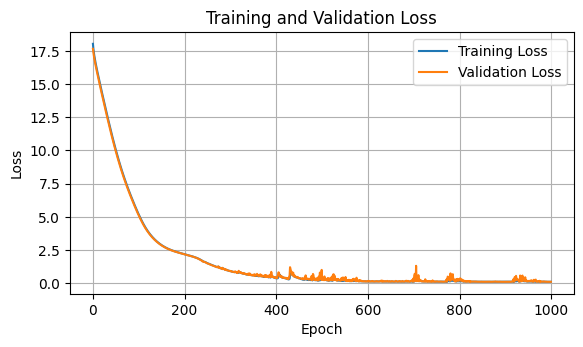

In [18]:
plot_train_val_loss(train_loss, test_loss)

In [19]:
os.makedirs(f"results/{results_folder}", exist_ok=True)
torch.save(train_loss, f"results/{results_folder}/train_loss.pt")
torch.save(test_loss, f"results/{results_folder}/test_loss.pt")

pickle.dump(activations, open(f"results/{results_folder}/activations.pkl", "wb"))

# Test

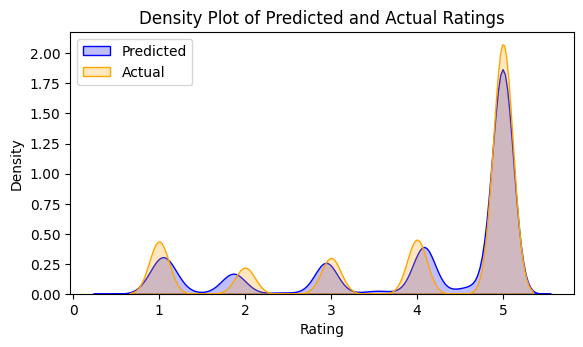

0.08113259077072144


In [20]:
model.load_state_dict(best_model)
best_loss, predictions = final_evaluation(model, test_edge_index, test_edge_weights, user_nodes, product_nodes, device, plot = True, print_test = False)
print(best_loss.item())

In [21]:
torch.save(predictions, f"results/{results_folder}/predictions.pt")

# Recomendations 

In [22]:
title_mapping = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = ["parent_asin", "title"])
prod_idx_to_id = {idx - offset: asin for asin, idx in prod_id_to_idx.items()}

In [23]:
# The pure random 
user_id = test_user_df.user_id.sample(1).item()
recommended_products, predictions, pred_ratings = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, ratings = True, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")
print(pred_ratings)

Product 1: 100 Pack of 90's Butterfly Hair Clips, 90's Accessories Hair Clips, Bulk Small Butterfly Hair Clips (100-Pack)
Product 2: Philips Norelco 9160XL SmartTouch-XL Men's Shaver
Product 3: Dental Care Water Flosser – Air Technology Oral Irrigator or Air Floss
Product 4: HAWAII FOREVER FLORALS PASSION PINEAPPLE PERFUME
Product 5: Helen of Troy 1517 Brush Iron, White, 1 Inch Barrel
Product 6: HAWAII FOREVER FLORALS PASSION PINEAPPLE PERFUME
Product 7: 15ml Magic Soak-Off Gel Nail Polish Remover, Professional Remover Nail Polish Delete Primer Acrylic Clean Degreaser For Nail Art Lacquer, Easily & Quickly
Product 8: Dior Sauvage Eau de Toilette for Men - .03 oz. Spray Sample
Product 9: HERMÈS Un Jardin sur la Lagune, Deluxe Mini.06 oz
Product 10: Philips Norelco 7775X Cool Skin Lotion Dispensing Shaver
tensor([4.1663, 4.1649, 4.1625, 4.1604, 4.1600, 4.1591, 4.1561, 4.1555, 4.1523,
        4.1513], device='cuda:0')


In [24]:
# The user with some data 
existing_test_users = test_user_df[test_user_df.user_id.isin(train_user_df.user_id)].copy()[["user_id"]]

In [25]:
user_id = existing_test_users.user_id.sample(1).item()
recommended_products, predictions, pred_ratings = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, ratings = True, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")
print(pred_ratings)

Product 1: Xtava Verona Infrared Professional Hair Dryer with Diffuser - Salon Blow Dryer Kit with Diffuser for Curly Hair and 2 Nozzle Attachments for Best Styling Results - 1200 Watt Quiet Turbo
Product 2: Reign - The Complete First, Second & Third Seasons (Season 1, Season 2, Season 3) [DVD]
Product 3: Wind Song by Prince Matchabelli for Women 3 Piece Set Includes: 0.55 oz Cologne Spray + 1.9 oz Body Lotion + 2.7 oz Dusting Powder
Product 4: Baby Signing Time DVD Collection
Product 5: BIEN ETRE EAU ESSENCES FRAICHES 500 ML
Product 6: Berta 1875 Watt Hair Dryer Salon Powerful Ceramic, Blow Dryer Pro Far Infrared Heat DC Motor, Hair Blower Low Noise Fast Dryer Cool Shot Button, Ionic Dryer, with Concentrator Nozzle Cola Red
Product 7: Hawaiian Maui Rain Perfume in Clear Glass Bottle 1/2 oz (0.5 oz) by Edward Bell
Product 8: Hot Tools NexGen Turbo Ionic Salon Dryer
Product 9: Jean Marc Paris - Fleur Paris Noir - Eau de Parfum Spray - 1.7 fl oz / 50 ml
Product 10: Linha Ekos Natura - Co

In [26]:
# count more than 10 purchases
min_unique_purchase = 10
item_count_df = test_user_edges.groupby("user_id").prod_idx.apply(lambda x: len(set(x))).reset_index()
dense_user_id = item_count_df[item_count_df["prod_idx"] >= min_unique_purchase][["user_id"]]

In [27]:
user_id = dense_user_id.user_id.sample(1).item()
recommended_products, predictions, pred_ratings = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, ratings = True, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")
print(pred_ratings)

user_df[user_df.user_id == user_id]

Product 1: 100 Pack of 90's Butterfly Hair Clips, 90's Accessories Hair Clips, Bulk Small Butterfly Hair Clips (100-Pack)
Product 2: Philips Norelco 9160XL SmartTouch-XL Men's Shaver
Product 3: Dental Care Water Flosser – Air Technology Oral Irrigator or Air Floss
Product 4: HAWAII FOREVER FLORALS PASSION PINEAPPLE PERFUME
Product 5: Helen of Troy 1517 Brush Iron, White, 1 Inch Barrel
Product 6: HAWAII FOREVER FLORALS PASSION PINEAPPLE PERFUME
Product 7: 15ml Magic Soak-Off Gel Nail Polish Remover, Professional Remover Nail Polish Delete Primer Acrylic Clean Degreaser For Nail Art Lacquer, Easily & Quickly
Product 8: Dior Sauvage Eau de Toilette for Men - .03 oz. Spray Sample
Product 9: HERMÈS Un Jardin sur la Lagune, Deluxe Mini.06 oz
Product 10: Philips Norelco 7775X Cool Skin Lotion Dispensing Shaver
tensor([4.1663, 4.1649, 4.1625, 4.1604, 4.1600, 4.1591, 4.1561, 4.1555, 4.1523,
        4.1513], device='cuda:0')


,user_id,rating_mean,rating_count,helpful_vote_mean,helpful_vote_gte_1,verified_purchase_mean,last_active_in_days_min,last_active_in_days_max,word_count_mean,embedding
18860,AESI2BA4YODTHOSRFLJCSTAM6XDQ,5.0,1,0.0,0,1.0,1434,1460,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# Analysing predictions

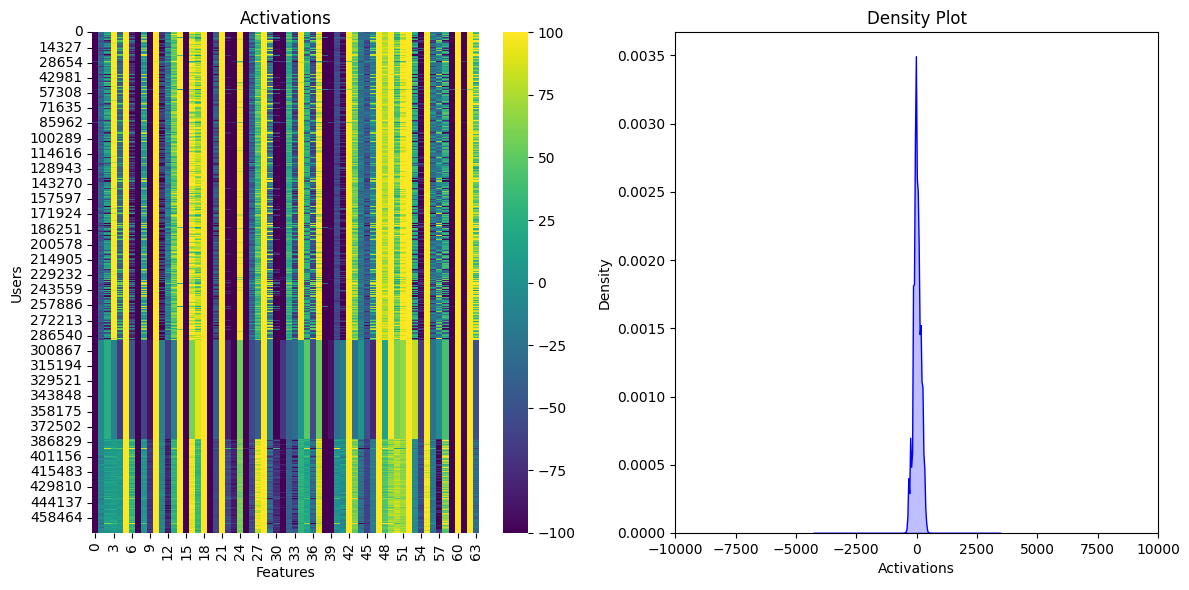

In [28]:
# Visualize activations of conv2 activation output
activations_of_interest = activations[model.conv2].detach().cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

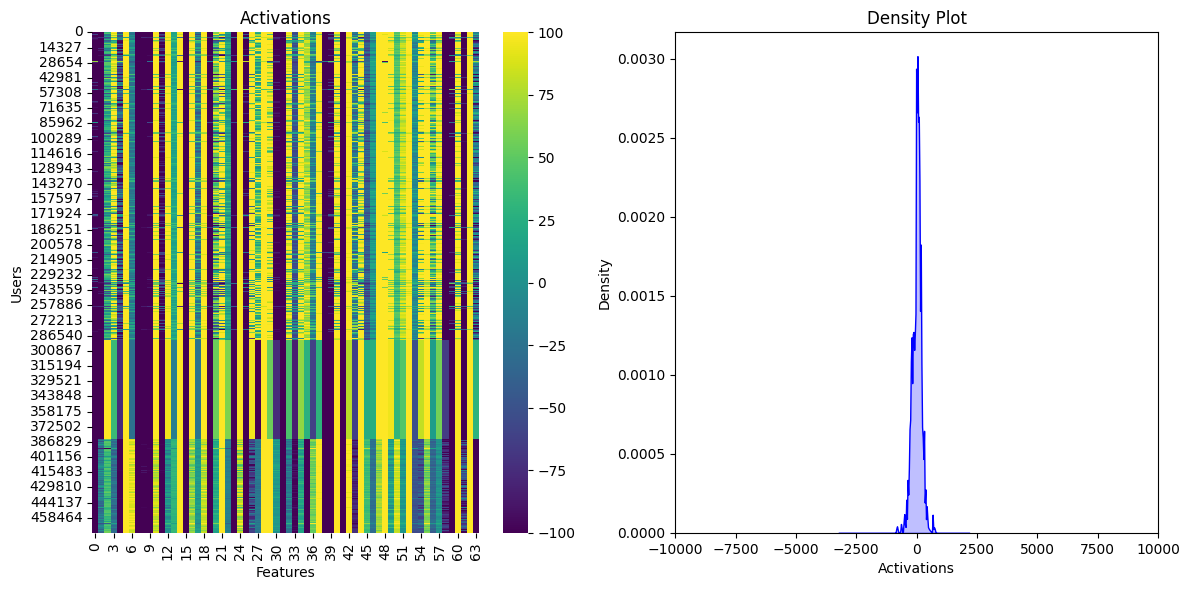

In [29]:
# Visualize activations of conv1 activation output
activations_of_interest = activations[model.conv1].detach().cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

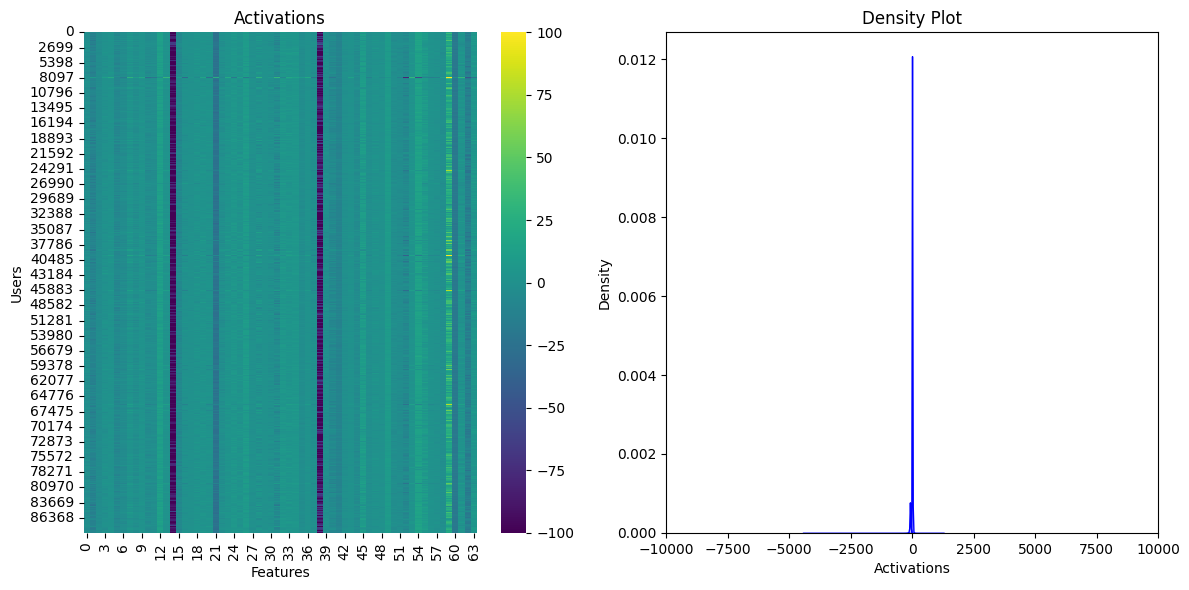

In [30]:
# Visualize activations of product_feature_transform activation output
activations_of_interest = activations[model.product_feature_transform].cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

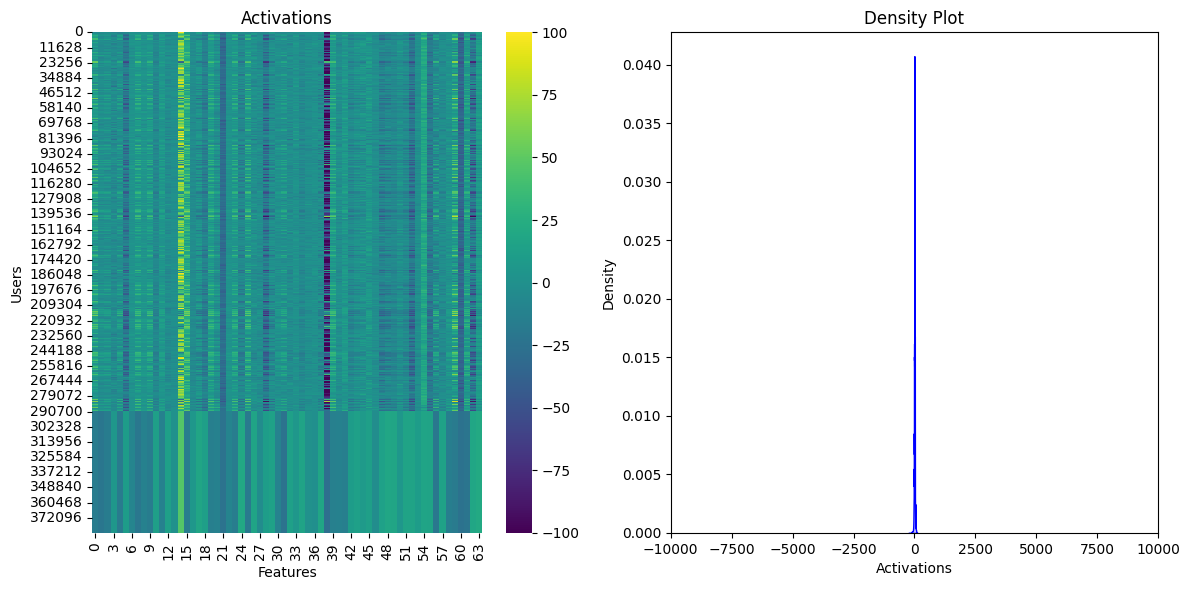

In [31]:
# Visualize activations of user_feature_transform activation output
activations_of_interest = activations[model.user_feature_transform].cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

# Metrics

In [32]:
product_idx_tensor = torch.tensor(list(prod_id_to_idx.values()), dtype=torch.long, device = device)
test_edges_grp = test_user_edges.groupby("user_idx").prod_idx.apply(list).reset_index()
test_edges_users = test_edges_grp.user_idx.to_list()

In [33]:
predictions = get_top_k_preds(model, test_edges_users, 10, 32, user_nodes, product_nodes, product_idx_tensor, device) # about 5 min to run
test_edges_grp["prediction"] = list(torch.vstack(predictions).cpu().numpy())
test_edges_grp["match_count"] = test_edges_grp.apply(lambda x: len(set(x.prod_idx).intersection(set(x.prediction))), axis = 1)

In [34]:
# Overall recall
(test_edges_grp["match_count"] / test_edges_grp.prod_idx.apply(len)).mean()

np.float64(0.0)

In [35]:
# Only those with prior history 
existing_test_edges_grp = test_edges_grp[test_edges_grp.user_idx.isin(train_user_df.user_id.apply(lambda x: user_id_to_idx[x]))]
(existing_test_edges_grp["match_count"] / existing_test_edges_grp.prod_idx.apply(len)).mean()

np.float64(0.0)

In [36]:
preds = set(y.item() for x in test_edges_grp.prediction for y in x)
len(preds)

270

In [37]:
test_edges_grp.to_parquet(f"results/{results_folder}/predictions.parquet")